# Makemore

- Building makemore Part 5: Building a WaveNet: https://www.youtube.com/watch?v=t3YJ5hKiMQ0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=6
- makemore on github: https://github.com/karpathy/makemore
- jupyter notebook: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part5_cnn1.ipynb
- collab notebook: https://colab.research.google.com/drive/1CXVEmCO_7r7WYZGb5qnjfyxTvQa13g5X?usp=sharing

In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [15]:
import re

def clean_text(text):
    """
    Cleans text for NLP tasks, removing non-Latin characters,
    irrelevant characters, extra whitespace, and converting to lowercase.

    Args:
        text: The input string to clean.

    Returns:
        The cleaned string.
    """

    if not isinstance(text, str):
        return ""

    # 1. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # 2. Remove email addresses
    text = re.sub(r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+", '', text)

    # 3. Remove mentions (@usernames)
    text = re.sub(r"@\S+", '', text)

    # 4. Remove special characters and punctuation (except apostrophes)
    text = re.sub(r"[^\w\s'’]", '', text)

    # 5. Remove numbers (optional)
    # text = re.sub(r"\d+", '', text)

    # 6. Remove extra whitespace
    text = re.sub(r"\s+", ' ', text).strip()

    # 8. Convert to lowercase
    text = text.lower()

    return text

In [16]:

# Read all the words in the file
# words = open('vietnamese_dataset/sample_vi_full_name.txt', 'r').read().splitlines()
words = open('vietnamese_dataset/names.txt', 'r').read().splitlines()

# words = open('vietnamese_dataset/sample_vi_name.txt', 'r').read().splitlines()
clean_words = [clean_text(word) for word in words]
clean_words[:10] 

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [17]:
len(clean_words)

32033

In [18]:
chars = sorted(list(set(''.join(clean_words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(f"{vocab_size=}")

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size=27


In [19]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(clean_words)

In [49]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(clean_words)
n1 = int(0.8*len(clean_words))
n2 = int(0.9*len(clean_words))

Xtr, Ytr = build_dataset(clean_words[:n1])
Xdev, Ydev = build_dataset(clean_words[n1:n2])
Xte, Yte = build_dataset(clean_words[n2:])

torch.Size([182441, 8]) torch.Size([182441])
torch.Size([22902, 8]) torch.Size([22902])
torch.Size([22803, 8]) torch.Size([22803])


In [50]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> l
......el --> i
.....eli --> a
....elia --> n
...elian --> y
..eliany --> s
.elianys --> .
........ --> t
.......t --> r
......tr --> o
.....tro --> y
....troy --> .
........ --> m
.......m --> a
......ma --> r
.....mar --> k
....mark --> u
...marku --> s
..markus --> .


In [88]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []
  
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1) #  hàm squeeze() được sử dụng để loại bỏ các chiều có kích thước bằng 1 từ một tensor.
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [89]:
torch.manual_seed(42); # seed rng for reproducibility

In [112]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [113]:
## Example dataset for debugging

ix = torch.randint(0, Xtr.shape[0], (4,)) # tensor([93360, 74659, 45326, 90954])
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape) # torch.Size([4, 8]), 4 samples, block_size=8 for each
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 19, 11],
        [ 0,  0,  0,  0,  0,  0,  0,  7],
        [ 0,  0,  0,  0,  0,  0,  9, 19],
        [ 0,  0,  2,  9, 19,  8, 15, 16]])

In [114]:
model.layers[0].out.shape # Output of embedding layer

torch.Size([4, 8, 10])

In [115]:
model.layers[1].out.shape # Output of flatten layer

torch.Size([4, 4, 20])

In [116]:
# Output of linear layer
# 4x80 @ 80xn_hidden (4x80 @ 80x200) = 4x200
model.layers[2].out.shape 

torch.Size([4, 4, 68])

In [117]:
# Vi du mo phong cho viec tao ra layers[2]
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape # X @ W + b

torch.Size([4, 200])

In [118]:
# Giờ muôn song song hóa tác vụ này, 
# Chúng ta có 4 sample, mỗi sample có 8 chars (context), mỗi char là 1 vector 10 chiều cho embeding
# Chúng ta có thể tách 8 chars thành các nhóm 2 chars một để tinh toán song song

(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape # X @ W + b

torch.Size([4, 4, 200])

In [119]:
# Để mà có đầu vào là (4,4,20) thì đầu ra của flatten layer phải là (4,4,20)
# Đầu vào của flatten layer là đầu ra của Embedding có kích thước cố định là (4, 8, 10)
# => do đó, cách flat phải khác đi, không phải flat hết 2 layer sau theo kiểu .view(x.shape[0], -1)
# Example:
out_emb = torch.randn(4, 8, 10) # torch.Size([4, 8, 10])
out_emb.view(out_emb.shape[0], int(block_size/2), -1 ).shape

# Hàm FlattenConsecutive chính là kết quả của phép tính toán này

torch.Size([4, 4, 20])

In [120]:
# Test trường hợp chia lẻ
f = FlattenConsecutive(2)
f(out_emb).shape

torch.Size([4, 4, 20])

In [123]:
for layer in model.layers:
  print(layer.__class__.__name__, ": ", tuple(layer.out.shape))

Embedding :  (32, 8, 10)
FlattenConsecutive :  (32, 4, 20)
Linear :  (32, 4, 68)
BatchNorm1d :  (32, 4, 68)
Tanh :  (32, 4, 68)
FlattenConsecutive :  (32, 2, 136)
Linear :  (32, 2, 68)
BatchNorm1d :  (32, 2, 68)
Tanh :  (32, 2, 68)
FlattenConsecutive :  (32, 136)
Linear :  (32, 68)
BatchNorm1d :  (32, 68)
Tanh :  (32, 68)
Linear :  (32, 27)


In [125]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break

      0/ 200000: 3.2638
  10000/ 200000: 1.9689
  20000/ 200000: 2.2232
  30000/ 200000: 1.9730
  40000/ 200000: 2.0327
  50000/ 200000: 1.6139
  60000/ 200000: 1.9162
  70000/ 200000: 2.4844
  80000/ 200000: 1.7300
  90000/ 200000: 1.9896
 100000/ 200000: 2.0914
 110000/ 200000: 2.2079
 120000/ 200000: 2.0892
 130000/ 200000: 2.1629
 140000/ 200000: 1.7706
 150000/ 200000: 1.9651
 160000/ 200000: 1.8559
 170000/ 200000: 1.9754
 180000/ 200000: 2.2447
 190000/ 200000: 1.9783


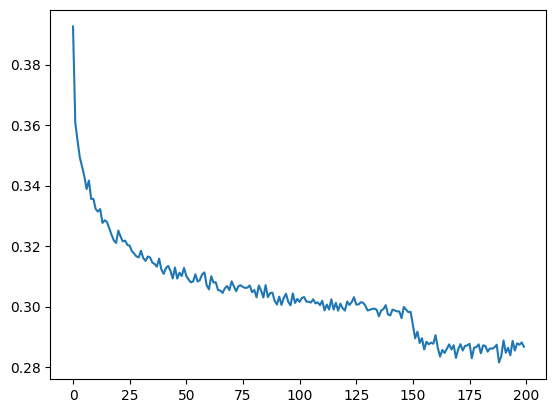

In [126]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [127]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [128]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9130876064300537
val 2.0189292430877686


In [129]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

junide.
jakari.
julissa.
adrianni.
ritoria.
sareem.
dameah.
yanilena.
jedediine.
amelys.
jainay.
arter.
nouum.
kyfon.
majan.
nishiah.
jaylie.
reaya.
jocklynn.
britten.


/tmp/ipykernel_125437/715180733.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)
